In [78]:
import os
import importlib
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn
from torch import optim

from torchinfo import summary

import utils
import dataset
importlib.reload(utils)
importlib.reload(dataset)

from utils import SEED, NUM_CLASSES


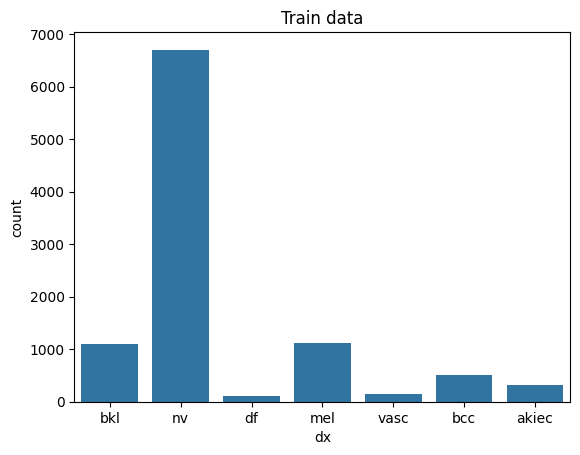

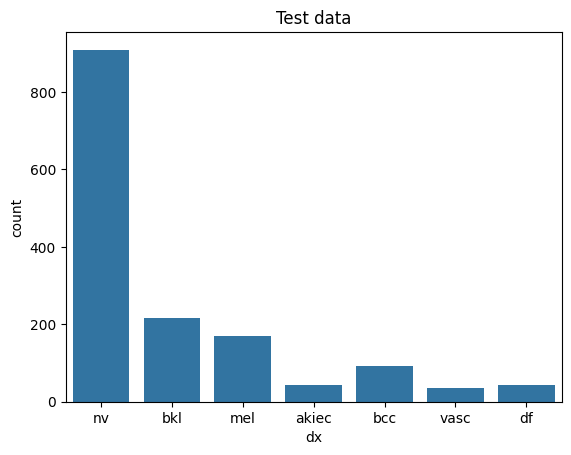

(9013, 10) (1002, 10) (1512, 10)


In [2]:
train_df, val_df, test_df = utils.load_data()

In [3]:
train_df = train_df[['image_id','dx','image_path']]
test_df = test_df[['image_id','dx','image_path']]
val_df = val_df[['image_id','dx','image_path']]

In [4]:
resnet_weights = ResNet50_Weights.DEFAULT
resnet_preprocess = resnet_weights.transforms()


resnet_le = LabelEncoder()

In [5]:
train_df

,image_id,dx,image_path
2770,ISIC_0026337,bcc,data/ham10000/images/ISIC_0026337.jpg
6445,ISIC_0028005,nv,data/ham10000/images/ISIC_0028005.jpg
8235,ISIC_0029667,nv,data/ham10000/images/ISIC_0029667.jpg
7308,ISIC_0033915,nv,data/ham10000/images/ISIC_0033915.jpg
7990,ISIC_0033015,nv,data/ham10000/images/ISIC_0033015.jpg
...,...,...,...
4418,ISIC_0030947,nv,data/ham10000/images/ISIC_0030947.jpg
7338,ISIC_0033370,nv,data/ham10000/images/ISIC_0033370.jpg
6853,ISIC_0031618,nv,data/ham10000/images/ISIC_0031618.jpg
3706,ISIC_0032367,nv,data/ham10000/images/ISIC_0032367.jpg


In [6]:
img_dir = os.path.dirname(train_df['image_path'][0])
print(img_dir)
test_img_dir = os.path.dirname(test_df['image_path'][0])
print(test_img_dir)
val_img_dir = os.path.dirname(val_df['image_path'][0])
print(val_img_dir)


data/ham10000/images
data/ham10000/images/test_images
data/ham10000/images


In [7]:
train_dataset_resnet = dataset.DataframeImageDataset(df=train_df,
                                      img_dir=img_dir,
                                      transform=resnet_preprocess,
                                      target_transform=resnet_le)
test_dataset_resnet = dataset.DataframeImageDataset(df=test_df,
                                             img_dir=test_img_dir,
                                             transform=resnet_preprocess,
                                             target_transform=resnet_le)
val_dataset_resnet = dataset.DataframeImageDataset(df=val_df,
                                             img_dir=val_img_dir,
                                             transform=resnet_preprocess,
                                             target_transform=resnet_le)

In [8]:
mean = resnet_preprocess.mean
std = resnet_preprocess.std

train_dataset_resnet[0]

(tensor([[[0.9646, 1.0159, 1.0331,  ..., 1.0844, 1.0844, 1.1187],
          [0.9817, 1.0331, 1.0502,  ..., 1.0673, 1.0331, 1.0844],
          [1.0331, 1.0502, 1.0502,  ..., 0.9817, 0.9817, 1.0331],
          ...,
          [1.1187, 1.1529, 1.1700,  ..., 0.8961, 0.8961, 0.8789],
          [1.1529, 1.2043, 1.2043,  ..., 0.8618, 0.8447, 0.8104],
          [1.1872, 1.1872, 1.1700,  ..., 0.8447, 0.8276, 0.7933]],
 
         [[0.9405, 1.0105, 1.0105,  ..., 1.0455, 1.0805, 1.0980],
          [0.9580, 1.0105, 1.0105,  ..., 1.0630, 1.0455, 1.0805],
          [1.0105, 1.0280, 0.9930,  ..., 0.9580, 0.9755, 1.0280],
          ...,
          [1.2031, 1.2206, 1.2381,  ..., 0.8354, 0.8354, 0.8179],
          [1.2381, 1.2731, 1.2731,  ..., 0.8179, 0.8004, 0.7654],
          [1.2731, 1.2731, 1.2556,  ..., 0.8179, 0.8004, 0.7479]],
 
         [[1.3677, 1.4025, 1.4374,  ..., 1.3154, 1.3502, 1.4374],
          [1.3851, 1.4200, 1.4548,  ..., 1.3328, 1.3328, 1.3677],
          [1.4200, 1.4374, 1.4200,  ...,

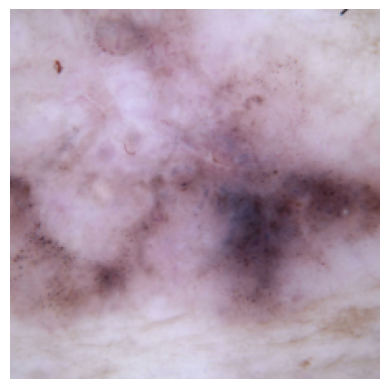

In [9]:
image = train_dataset_resnet[0][0]
utils.show_image(image, mean, std)

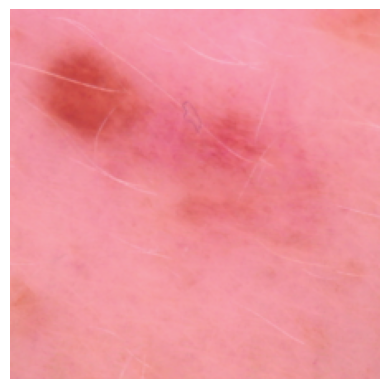

In [10]:
image = test_dataset_resnet[0][0]
utils.show_image(image, mean, std)

In [11]:
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=True)
val_dataloader_resnet = DataLoader(val_dataset_resnet, batch_size=64, shuffle=True)

In [12]:
resnet = resnet50(weights=resnet_weights)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, NUM_CLASSES)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=3e-4, weight_decay=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [14]:
torch.save(resnet.state_dict(), "untrained_resnet50.pth")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

utils.train_model(resnet, train_dataloader_resnet, val_dataloader_resnet, criterion, optimizer, scheduler, device=device, num_epochs=20)

🔹 Starting epoch 1/20
[Train] Epoch 1/20, Batch 10/141 - Loss: 1.2431
[Train] Epoch 1/20, Batch 20/141 - Loss: 0.9146
[Train] Epoch 1/20, Batch 30/141 - Loss: 0.8407
[Train] Epoch 1/20, Batch 40/141 - Loss: 0.7149
[Train] Epoch 1/20, Batch 50/141 - Loss: 0.7098
[Train] Epoch 1/20, Batch 60/141 - Loss: 0.6565
[Train] Epoch 1/20, Batch 70/141 - Loss: 0.6417
[Train] Epoch 1/20, Batch 80/141 - Loss: 0.5720
[Train] Epoch 1/20, Batch 90/141 - Loss: 0.5808
[Train] Epoch 1/20, Batch 100/141 - Loss: 0.5336
[Train] Epoch 1/20, Batch 110/141 - Loss: 0.4766
[Train] Epoch 1/20, Batch 120/141 - Loss: 0.4714
[Train] Epoch 1/20, Batch 130/141 - Loss: 0.4685
[Train] Epoch 1/20, Batch 140/141 - Loss: 0.5402
✅ Epoch 1 Finished. Train Loss: 0.6699
📊 Validation Loss: 0.5183, Accuracy: 80.34%
🔹 Starting epoch 2/20
[Train] Epoch 2/20, Batch 10/141 - Loss: 0.3961
[Train] Epoch 2/20, Batch 20/141 - Loss: 0.3344
[Train] Epoch 2/20, Batch 30/141 - Loss: 0.3220
[Train] Epoch 2/20, Batch 40/141 - Loss: 0.3735
[Tra

In [16]:
utils.eval_model(resnet, test_dataloader_resnet, device)

Accuracy of the network on the test images: 76 %


In [17]:
googlenet_weights = GoogLeNet_Weights.DEFAULT
googlenet_preprocess = googlenet_weights.transforms()

googlenet_le = LabelEncoder()

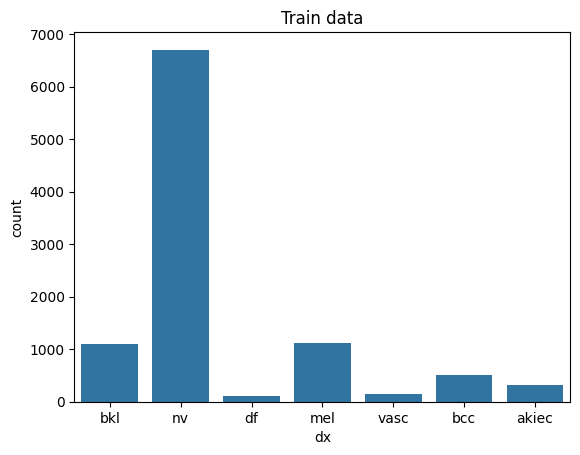

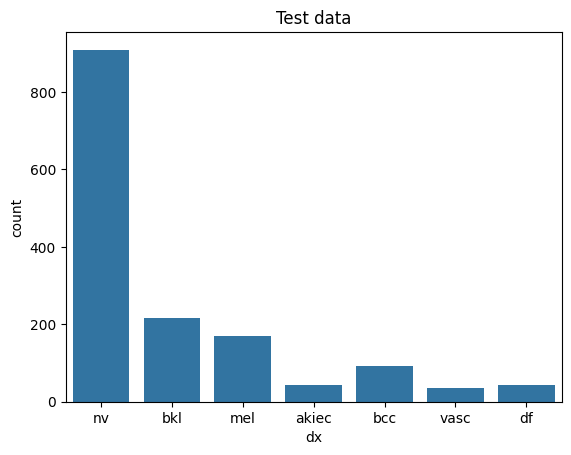

(9013, 10) (1002, 10) (1512, 10)


In [18]:
train_df, val_df, test_df = utils.load_data()

In [19]:

train_df = train_df[['image_id','dx','image_path']]
val_df = val_df[['image_id','dx','image_path']]
test_df = test_df[['image_id','dx','image_path']]

In [20]:

img_dir = os.path.dirname(train_df['image_path'][0])
print(img_dir)
test_img_dir = os.path.dirname(test_df['image_path'][0])
print(test_img_dir)
val_img_dir = os.path.dirname(val_df['image_path'][0])
print(test_img_dir)


data/ham10000/images
data/ham10000/images/test_images
data/ham10000/images/test_images


In [21]:
train_dataset_googlenet = dataset.DataframeImageDataset(df=train_df,
                                      img_dir=img_dir,
                                      transform=googlenet_preprocess,
                                      target_transform=googlenet_le)
test_dataset_googlenet = dataset.DataframeImageDataset(df=test_df,
                                             img_dir=test_img_dir,
                                             transform=googlenet_preprocess,
                                             target_transform=googlenet_le)
val_dataset_googlenet = dataset.DataframeImageDataset(df=val_df,
                                             img_dir=val_img_dir,
                                             transform=googlenet_preprocess,
                                             target_transform=googlenet_le)

In [22]:
train_dataloader_googlenet = DataLoader(train_dataset_googlenet, batch_size=64, shuffle=True)
test_dataloader_googlenet = DataLoader(test_dataset_googlenet, batch_size=64, shuffle=True)
val_dataloader_googlenet = DataLoader(val_dataset_googlenet, batch_size=64, shuffle=True)

In [23]:
mean = googlenet_preprocess.mean
std = googlenet_preprocess.std

train_dataset_googlenet[0]


(tensor([[[1.1529, 1.1187, 1.0844,  ..., 1.1358, 1.1872, 1.1700],
          [1.1700, 1.1358, 1.1015,  ..., 1.1358, 1.1872, 1.1872],
          [1.1872, 1.1529, 1.1187,  ..., 1.2385, 1.2385, 1.1872],
          ...,
          [1.1529, 1.1529, 1.2043,  ..., 0.8276, 0.8104, 0.7762],
          [1.2214, 1.2214, 1.2043,  ..., 0.7933, 0.7591, 0.7591],
          [1.2557, 1.2557, 1.2214,  ..., 0.7591, 0.7591, 0.7419]],
 
         [[1.0805, 1.0105, 0.9230,  ..., 1.0980, 1.1506, 1.1506],
          [1.0980, 1.0455, 0.9055,  ..., 1.0980, 1.1681, 1.1506],
          [1.1331, 1.0805, 1.0105,  ..., 1.1856, 1.2206, 1.1681],
          ...,
          [1.1681, 1.1681, 1.2206,  ..., 0.7829, 0.7654, 0.7304],
          [1.2381, 1.2206, 1.2206,  ..., 0.7304, 0.6954, 0.6954],
          [1.2731, 1.2731, 1.2556,  ..., 0.7129, 0.7129, 0.6954]],
 
         [[1.5420, 1.4897, 1.4025,  ..., 1.2980, 1.4548, 1.4548],
          [1.6117, 1.5594, 1.4374,  ..., 1.4025, 1.5071, 1.5245],
          [1.6291, 1.5942, 1.5420,  ...,

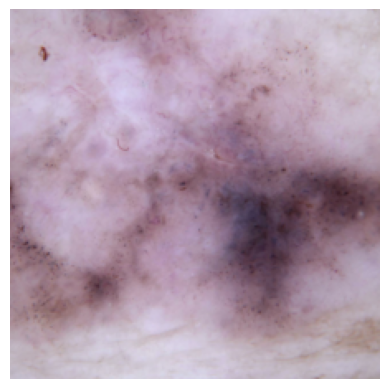

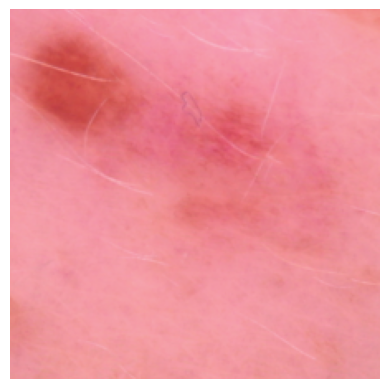

In [24]:
image = train_dataset_googlenet[0][0]
utils.show_image(image, mean, std)
image = test_dataset_googlenet[0][0]
utils.show_image(image, mean, std)


In [25]:
google = googlenet(weights=googlenet_weights)
google.aux_logits = False
google.aux1 = None
google.aux2 = None
in_features = google.fc.in_features
google.fc = nn.Linear(in_features, NUM_CLASSES)

In [26]:
summary(google)

Layer (type:depth-idx)                   Param #
GoogLeNet                                --
├─BasicConv2d: 1-1                       --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
├─MaxPool2d: 1-2                         --
├─BasicConv2d: 1-3                       --
│    └─Conv2d: 2-3                       4,096
│    └─BatchNorm2d: 2-4                  128
├─BasicConv2d: 1-4                       --
│    └─Conv2d: 2-5                       110,592
│    └─BatchNorm2d: 2-6                  384
├─MaxPool2d: 1-5                         --
├─Inception: 1-6                         --
│    └─BasicConv2d: 2-7                  --
│    │    └─Conv2d: 3-1                  12,288
│    │    └─BatchNorm2d: 3-2             128
│    └─Sequential: 2-8                   --
│    │    └─BasicConv2d: 3-3             18,624
│    │    └─BasicConv2d: 3-4             110,848
│    └─Sequential: 2-9                   --
│    │    └─BasicConv2d: 3-5             3,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(google.parameters(), lr=3e-4, weight_decay=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [28]:
torch.save(google.state_dict(), "untrained_googlenet.pth")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

utils.train_model(google, train_dataloader_googlenet, val_dataloader_googlenet, criterion, optimizer, scheduler,  device, num_epochs=20)

🔹 Starting epoch 1/20
[Train] Epoch 1/20, Batch 10/141 - Loss: 1.2681
[Train] Epoch 1/20, Batch 20/141 - Loss: 0.8452
[Train] Epoch 1/20, Batch 30/141 - Loss: 0.6951
[Train] Epoch 1/20, Batch 40/141 - Loss: 0.6421
[Train] Epoch 1/20, Batch 50/141 - Loss: 0.6602
[Train] Epoch 1/20, Batch 60/141 - Loss: 0.6381
[Train] Epoch 1/20, Batch 70/141 - Loss: 0.5781
[Train] Epoch 1/20, Batch 80/141 - Loss: 0.5646
[Train] Epoch 1/20, Batch 90/141 - Loss: 0.5189
[Train] Epoch 1/20, Batch 100/141 - Loss: 0.5583
[Train] Epoch 1/20, Batch 110/141 - Loss: 0.5831
[Train] Epoch 1/20, Batch 120/141 - Loss: 0.5683
[Train] Epoch 1/20, Batch 130/141 - Loss: 0.5296
[Train] Epoch 1/20, Batch 140/141 - Loss: 0.4991
✅ Epoch 1 Finished. Train Loss: 0.6515
📊 Validation Loss: 0.5396, Accuracy: 79.64%
🔹 Starting epoch 2/20
[Train] Epoch 2/20, Batch 10/141 - Loss: 0.3703
[Train] Epoch 2/20, Batch 20/141 - Loss: 0.3579
[Train] Epoch 2/20, Batch 30/141 - Loss: 0.3746
[Train] Epoch 2/20, Batch 40/141 - Loss: 0.3137
[Tra

In [30]:
utils.eval_model(google, test_dataloader_googlenet, device)

Accuracy of the network on the test images: 75 %


In [31]:
mobilenet_weights = MobileNet_V3_Large_Weights.DEFAULT
mobilenet_preprocess = mobilenet_weights.transforms()

mobilenet_le = LabelEncoder()

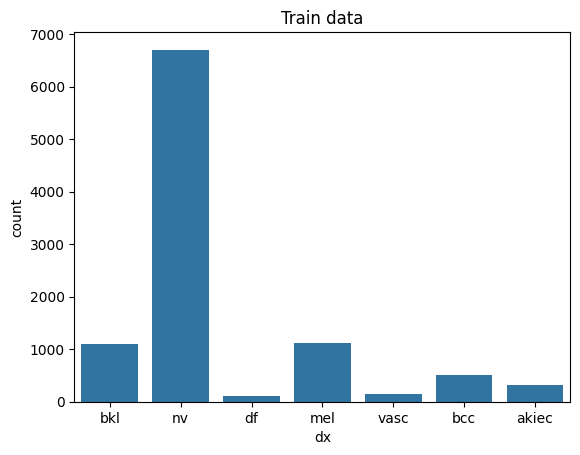

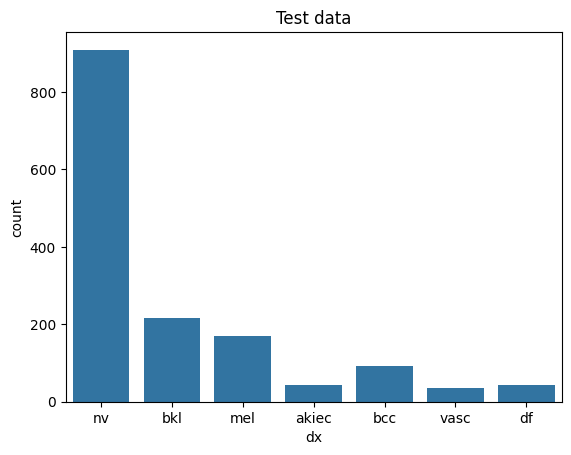

(9013, 10) (1002, 10) (1512, 10)


In [32]:
train_df, val_df, test_df = utils.load_data()

In [33]:
train_df = train_df[['image_id','dx','image_path']]
test_df = test_df[['image_id','dx','image_path']]
val_df = val_df[['image_id','dx','image_path']]

In [34]:
img_dir = os.path.dirname(train_df['image_path'][0])
print(img_dir)
test_img_dir = os.path.dirname(test_df['image_path'][0])
print(test_img_dir)
val_img_dir = os.path.dirname(val_df['image_path'][0])
print(test_img_dir)

data/ham10000/images
data/ham10000/images/test_images
data/ham10000/images/test_images


In [35]:
train_dataset_mobilenet = dataset.DataframeImageDataset(df=train_df,
                                      img_dir=img_dir,
                                      transform=mobilenet_preprocess,
                                      target_transform=mobilenet_le)
test_dataset_mobilenet= dataset.DataframeImageDataset(df=test_df,
                                             img_dir=test_img_dir,
                                             transform=mobilenet_preprocess,
                                             target_transform=mobilenet_le)
val_dataset_mobilenet= dataset.DataframeImageDataset(df=val_df,
                                             img_dir=val_img_dir,
                                             transform=mobilenet_preprocess,
                                             target_transform=mobilenet_le)

In [36]:
train_dataloader_mobilenet = DataLoader(train_dataset_mobilenet, batch_size=64, shuffle=True)
test_dataloader_mobilenet = DataLoader(test_dataset_mobilenet, batch_size=64, shuffle=True)
val_dataloader_mobilenet = DataLoader(val_dataset_mobilenet, batch_size=64, shuffle=True)

In [37]:
mean = mobilenet_preprocess.mean
std = mobilenet_preprocess.std

train_dataset_mobilenet[0]

(tensor([[[0.9646, 1.0159, 1.0331,  ..., 1.0844, 1.0844, 1.1187],
          [0.9817, 1.0331, 1.0502,  ..., 1.0673, 1.0331, 1.0844],
          [1.0331, 1.0502, 1.0502,  ..., 0.9817, 0.9817, 1.0331],
          ...,
          [1.1187, 1.1529, 1.1700,  ..., 0.8961, 0.8961, 0.8789],
          [1.1529, 1.2043, 1.2043,  ..., 0.8618, 0.8447, 0.8104],
          [1.1872, 1.1872, 1.1700,  ..., 0.8447, 0.8276, 0.7933]],
 
         [[0.9405, 1.0105, 1.0105,  ..., 1.0455, 1.0805, 1.0980],
          [0.9580, 1.0105, 1.0105,  ..., 1.0630, 1.0455, 1.0805],
          [1.0105, 1.0280, 0.9930,  ..., 0.9580, 0.9755, 1.0280],
          ...,
          [1.2031, 1.2206, 1.2381,  ..., 0.8354, 0.8354, 0.8179],
          [1.2381, 1.2731, 1.2731,  ..., 0.8179, 0.8004, 0.7654],
          [1.2731, 1.2731, 1.2556,  ..., 0.8179, 0.8004, 0.7479]],
 
         [[1.3677, 1.4025, 1.4374,  ..., 1.3154, 1.3502, 1.4374],
          [1.3851, 1.4200, 1.4548,  ..., 1.3328, 1.3328, 1.3677],
          [1.4200, 1.4374, 1.4200,  ...,

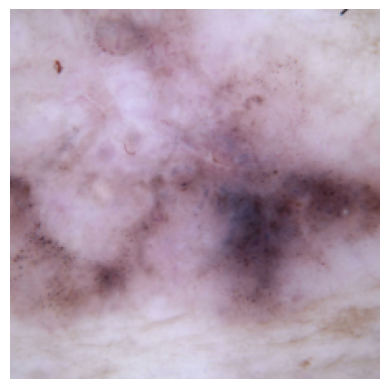

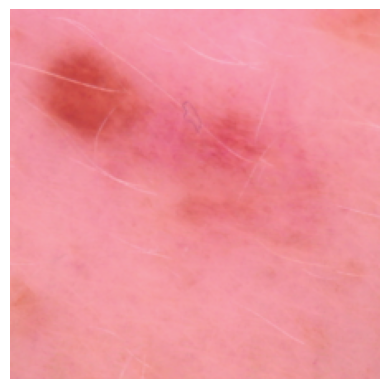

In [38]:
image = train_dataset_mobilenet[0][0]
utils.show_image(image, mean, std)
image = test_dataset_mobilenet[0][0]
utils.show_image(image, mean, std)

In [39]:
mobilenet = mobilenet_v3_large(weights=mobilenet_weights)

In [40]:
in_features = mobilenet.classifier[3].in_features
mobilenet.classifier[3] = nn.Linear(in_features, NUM_CLASSES)

In [41]:
summary(mobilenet)

Layer (type:depth-idx)                             Param #
MobileNetV3                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            432
│    │    └─BatchNorm2d: 3-2                       32
│    │    └─Hardswish: 3-3                         --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        464
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        3,440
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        4,440
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,328
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        20,992
│    └─InvertedResidual: 2-7                       --
│    │ 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(mobilenet.parameters(), lr=3e-4, weight_decay=1e-2, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

In [43]:
torch.save(mobilenet.state_dict(), "untrained_mobilenet.pth")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

utils.train_model(mobilenet, train_dataloader_mobilenet, val_dataloader_mobilenet, criterion, optimizer, None, device, num_epochs=20)

🔹 Starting epoch 1/20
[Train] Epoch 1/20, Batch 10/141 - Loss: 1.2396
[Train] Epoch 1/20, Batch 20/141 - Loss: 0.8452
[Train] Epoch 1/20, Batch 30/141 - Loss: 0.8272
[Train] Epoch 1/20, Batch 40/141 - Loss: 0.6911
[Train] Epoch 1/20, Batch 50/141 - Loss: 0.6387
[Train] Epoch 1/20, Batch 60/141 - Loss: 0.5857
[Train] Epoch 1/20, Batch 70/141 - Loss: 0.5763
[Train] Epoch 1/20, Batch 80/141 - Loss: 0.5739
[Train] Epoch 1/20, Batch 90/141 - Loss: 0.5049
[Train] Epoch 1/20, Batch 100/141 - Loss: 0.4910
[Train] Epoch 1/20, Batch 110/141 - Loss: 0.5240
[Train] Epoch 1/20, Batch 120/141 - Loss: 0.5105
[Train] Epoch 1/20, Batch 130/141 - Loss: 0.4489
[Train] Epoch 1/20, Batch 140/141 - Loss: 0.4624
✅ Epoch 1 Finished. Train Loss: 0.6350
📊 Validation Loss: 0.9040, Accuracy: 73.05%
🔹 Starting epoch 2/20
[Train] Epoch 2/20, Batch 10/141 - Loss: 0.3636
[Train] Epoch 2/20, Batch 20/141 - Loss: 0.2956
[Train] Epoch 2/20, Batch 30/141 - Loss: 0.3173
[Train] Epoch 2/20, Batch 40/141 - Loss: 0.3237
[Tra

In [45]:
utils.eval_model(mobilenet, test_dataloader_mobilenet, device)

Accuracy of the network on the test images: 80 %


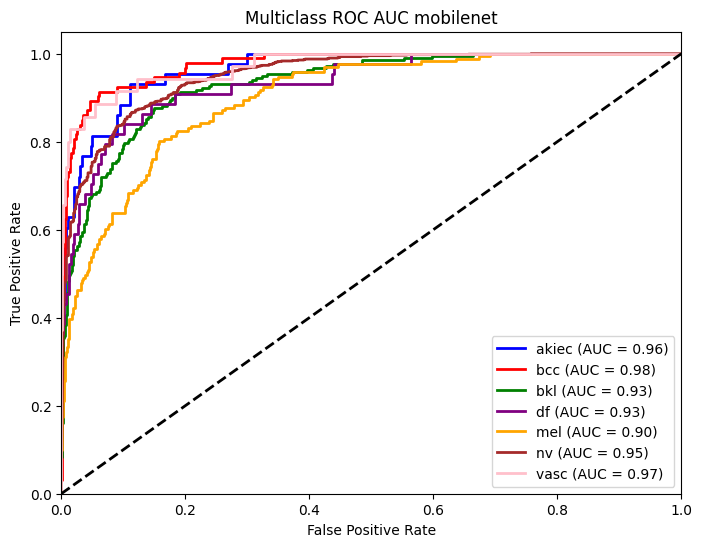

In [51]:
utils.plot_multiclass_roc(mobilenet, test_dataloader_mobilenet, mobilenet_le, model_name='mobilenet')

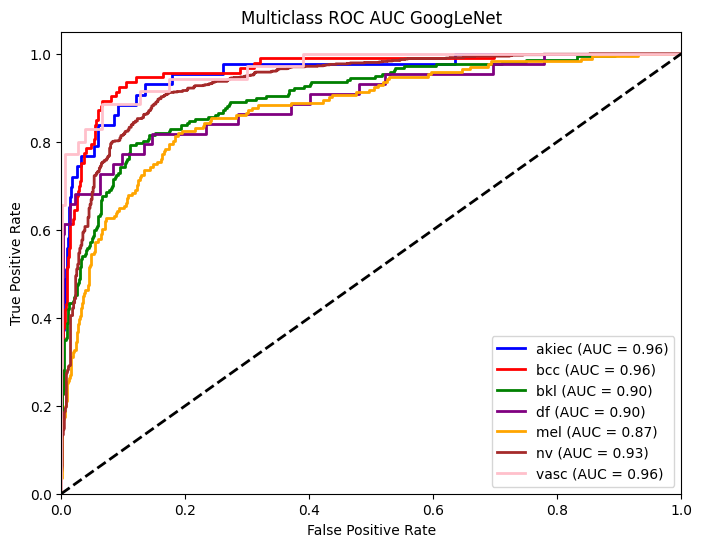

In [52]:
utils.plot_multiclass_roc(google, test_dataloader_googlenet, googlenet_le, model_name='GoogLeNet')

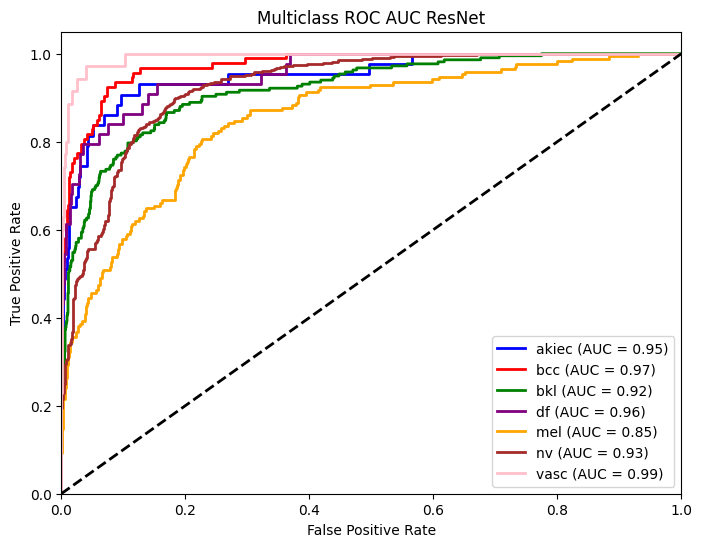

In [53]:
utils.plot_multiclass_roc(resnet, test_dataloader_resnet, resnet_le, model_name='ResNet')

In [49]:
torch.save(resnet.state_dict(), "trained_resnet50_20_epochs.pth")
torch.save(google.state_dict(), "trained_googlenet_20_epochs.pth")
torch.save(mobilenet.state_dict(), "trained_mobilenet_20_epochs.pth")

In [70]:
resnet_ovo, resnet_ovr = utils.calculate_auc(resnet, test_dataloader_resnet, resnet_le)
google_ovo, google_ovr = utils.calculate_auc(google, test_dataloader_googlenet, googlenet_le)
mobilenet_ovo, mobilenet_ovr = utils.calculate_auc(mobilenet, test_dataloader_mobilenet, mobilenet_le)


In [71]:
print(f'ResNet50 OVO AUC (One versus One): {resnet_ovo}')
print(f'ResNet50 OVR AUC (One versus Rest): {resnet_ovr}')
print(f'GoogLeNet OVO AUC (One versus One): {google_ovo}')
print(f'GoogLeNet OVR AUC (One versus Rest): {google_ovr}')
print(f'MobileNet OVO AUC (One versus One): {mobilenet_ovo}')
print(f'MobileNet OVR AUC (One versus Rest): {mobilenet_ovr}')

ResNet50 OVO AUC (One versus One): 0.9391411892841702
ResNet50 OVR AUC (One versus Rest): 0.9391411892841702
GoogLeNet OVO AUC (One versus One): 0.9270765699507326
GoogLeNet OVR AUC (One versus Rest): 0.9270765699507326
MobileNet OVO AUC (One versus One): 0.9471380896078998
MobileNet OVR AUC (One versus Rest): 0.9471380896078998


In [72]:

resnet_avg_auc = (resnet_ovo + resnet_ovr) / 2
googlenet_avg_auc = (google_ovo + google_ovr) / 2
mobilenet_avg_auc = (mobilenet_ovo + mobilenet_ovr) / 2

print(f'ResNet50 Average AUC: {resnet_avg_auc}')
print(f'GoogLeNet Average AUC: {googlenet_avg_auc}')
print(f'MobileNet Average AUC: {mobilenet_avg_auc}')

ResNet50 Average AUC: 0.9391411892841702
GoogLeNet Average AUC: 0.9270765699507326
MobileNet Average AUC: 0.9471380896078998


In [76]:
resnet_f1 = utils.calculate_f1(resnet, test_dataloader_resnet, resnet_le)
google_f1 = utils.calculate_f1(google, test_dataloader_googlenet, googlenet_le)
mobilenet_f1 = utils.calculate_f1(mobilenet, test_dataloader_mobilenet, mobilenet_le)

print(f'ResNet50 F1 Score: {resnet_f1}')
print(f'GoogLeNet F1 Score: {google_f1}')
print(f'MobileNet F1 Score: {mobilenet_f1}')

ResNet50 F1 Score: 0.7662075710274303
GoogLeNet F1 Score: 0.7589226955503908
MobileNet F1 Score: 0.7890163757236773


In [79]:
resnet_accuracy = utils.calculate_accuracy(resnet, test_dataloader_resnet, resnet_le)
google_accuracy = utils.calculate_accuracy(google, test_dataloader_googlenet, googlenet_le)
mobilenet_accuracy = utils.calculate_accuracy(mobilenet, test_dataloader_mobilenet, mobilenet_le)

print(f'ResNet50 Accuracy: {resnet_accuracy}')
print(f'GoogLeNet Accuracy: {google_accuracy}')
print(f'MobileNet Accuracy: {mobilenet_accuracy}')

ResNet50 Accuracy: 76.52116402116403
GoogLeNet Accuracy: 75.72751322751323
MobileNet Accuracy: 80.0925925925926
